In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 22 09:26:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("./gdrive/MyDrive/ML DL datasets"))

['fakeimage_detection_2.zip', 'deep_fake_detec1', 'deep_fake_detec2', 'deep_fake_detec3', 'fakeimage_detection_3.zip', 'fake_image_detection_4.zip']


In [ ]:
# unzp archive
!unzip "./gdrive/MyDrive/ML DL datasets/fake_image_detection_4.zip"

In [6]:
training_path = './fakeimage_detection_3/train'
test_path = './fakeimage_detection_3/test'
validation_path = './fakeimage_detection_3/validation'
!ls

fakeimage_detection_3  gdrive  __MACOSX  sample_data


In [7]:
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print(tf. __version__) 

2.7.0


In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
# import keras
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                  #  rotation_range = 10,
                                  #  width_shift_range = 0.1,
                                  #  height_shift_range = 0.1,
                                   horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
batch_size = 64
input_size=128
training_set = train_datagen.flow_from_directory(training_path,
                                                 target_size = (input_size, input_size),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

Found 97997 images belonging to 7 classes.


In [11]:
validation_set = valid_datagen.flow_from_directory(validation_path,
                                                 target_size = (input_size, input_size),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

Found 5248 images belonging to 7 classes.


In [12]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=2, baseline=0.801, min_delta=0.001)
checkpoint_filepath = '/content/gdrive/MyDrive/dl_models/checkpoint'
custom_callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        mode = 'min',
        patience = 5,
        verbose = 1
    ),
    ModelCheckpoint(
        filepath = os.path.join(checkpoint_filepath, 'best_base_model_7classification.h5'),
        monitor = 'val_loss',
        mode = 'min',
        verbose = 1,
        save_best_only = True
    )
]

In [13]:
# # Baseline model
classifier = Sequential()
classifier.add(Conv2D(3, (3, 3), input_shape = (input_size, input_size, 3)))
classifier.add(Conv2D(24, (3, 3)))
classifier.add(Conv2D(64, (3, 3)))

classifier.summary()
classifier.add(Flatten())

classifier.add(Dense(units = 300))
classifier.add(Dense(units = 128))
classifier.add(Dense(units = 7, activation = 'softmax'))
classifier.compile(optimizer = optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 126, 126, 3)      39        
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 124, 124, 24)     123       
 leConv2D)                                                       
                                                                 
 separable_conv2d_2 (Separab  (None, 122, 122, 64)     1816      
 leConv2D)                                                       
                                                                 
Total params: 1,978
Trainable params: 1,978
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 1693 or 3386
history = classifier.fit(
                        training_set,
                        steps_per_epoch=len(training_set),
                        epochs=10,
                        verbose=1,
                        validation_data=validation_set,
                        callbacks = custom_callbacks
                         )

Epoch 1/10
1532/1532 [==============================] - ETA: 0s - loss: 1.5703 - accuracy: 0.4459
Epoch 00001: val_loss improved from inf to 1.15200, saving model to /content/gdrive/MyDrive/dl_models/checkpoint/best_base_model_7classification.h5
1532/1532 [==============================] - 768s 491ms/step - loss: 1.5703 - accuracy: 0.4459 - val_loss: 1.1520 - val_accuracy: 0.4644
Epoch 2/10
1532/1532 [==============================] - ETA: 0s - loss: 1.1604 - accuracy: 0.4648
Epoch 00002: val_loss improved from 1.15200 to 1.14482, saving model to /content/gdrive/MyDrive/dl_models/checkpoint/best_base_model_7classification.h5
1532/1532 [==============================] - 802s 522ms/step - loss: 1.1604 - accuracy: 0.4648 - val_loss: 1.1448 - val_accuracy: 0.4703
Epoch 3/10
1532/1532 [==============================] - ETA: 0s - loss: 1.1669 - accuracy: 0.4634
Epoch 00003: val_loss did not improve from 1.14482
1532/1532 [==============================] - 767s 499ms/step - loss: 1.1669 - acc

In [ ]:
save_path = '/content/gdrive/MyDrive/dl_models/'
model_name = 'categorical_fake_image_classifierEfB80.h5'
classifier.save(save_path + model_name)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
!ls  /content/gdrive/MyDrive/dl_models

fake_image_classifierEfB80.h5


In [18]:
from keras.models import load_model
best_model = '/content/gdrive/MyDrive/dl_models/checkpoint/best_base_model_7classification.h5'
model = load_model(best_model)

**Prediction section**

In [19]:
def predict_images(folder, image_name):
    #Making Single new prediction
    import numpy as np
    #from keras.preprocessing.image import image
    import keras.preprocessing.image as image
    test_image = image.load_img(f'./fakeimage_detection_3/test/{folder}/{image_name}', target_size = (input_size, input_size))
    test_image = image.img_to_array(test_image)
    test_image = test_image /255.
    #use this function to change the image from 2dimension(64, 64) to 3dimension(64, 64, 3)
    test_image = np.expand_dims(test_image, axis=0)
    #add one more dimension before predicting because the predict method expects a batch
    images = np.vstack([test_image])
    result = model.predict(images, batch_size=10)

    prediction = ''
    if np.argmax(result) == 0:
        prediction = 'celeba'
        # print('fake')
    elif np.argmax(result) == 1:
        # print('real')
        prediction = 'celeba_hq'
    elif np.argmax(result) == 2:
        prediction = 'deepfakes'
    elif np.argmax(result) == 3:
        prediction = 'face2face'
    elif np.argmax(result) == 4:
        prediction = 'faceswap'
    elif np.argmax(result) == 5:
        prediction = 'neuraltextures'
    elif np.argmax(result) == 6:
        prediction = 'youtube'
#     print(image_name, prediction)
    # print(prediction)
    return prediction

In [20]:

import os
celeba_images = os.listdir("./fakeimage_detection_3/test/celeba")
celeba_hq_images = os.listdir("./fakeimage_detection_3/test/celeba_hq")
youtube_images = os.listdir("./fakeimage_detection_3/test/youtube")
deepfakes_images = os.listdir("./fakeimage_detection_3/test/deepfakes")
face2face_images = os.listdir("./fakeimage_detection_3/test/face2face")
faceswap_images = os.listdir("./fakeimage_detection_3/test/faceswap")
neuraltextures_images = os.listdir("./fakeimage_detection_3/test/neuraltextures")
res_celeba = []
res_celeba_hq = []
res_youtube = []
res_deepfakes = []
res_face2face = []
res_faceswap = []
res_neuraltextures = []
for image_name in celeba_images:
    res_celeba.append(predict_images('celeba', image_name))
for image_name in celeba_hq_images:
    res_celeba_hq.append(predict_images('celeba_hq', image_name))
for image_name in youtube_images:
    res_youtube.append(predict_images('youtube', image_name))
for image_name in deepfakes_images:
    res_deepfakes.append(predict_images('deepfakes', image_name))
for image_name in face2face_images:
    res_face2face.append(predict_images('face2face', image_name))
for image_name in faceswap_images:
    res_faceswap.append(predict_images('faceswap', image_name))
for image_name in neuraltextures_images:
    res_neuraltextures.append(predict_images('neuraltextures', image_name))

In [21]:
from collections import Counter
results = (Counter(res_celeba), Counter(res_celeba_hq), Counter(res_youtube), Counter(res_deepfakes), Counter(res_face2face), Counter(res_faceswap), Counter(res_neuraltextures))
results

(Counter({'celeba': 1976,
          'celeba_hq': 13,
          'deepfakes': 5,
          'face2face': 1,
          'faceswap': 1,
          'youtube': 4}),
 Counter({'celeba': 7,
          'celeba_hq': 1988,
          'deepfakes': 1,
          'face2face': 3,
          'neuraltextures': 1}),
 Counter({'celeba_hq': 3,
          'deepfakes': 477,
          'face2face': 160,
          'faceswap': 730,
          'neuraltextures': 17,
          'youtube': 613}),
 Counter({'celeba_hq': 2,
          'deepfakes': 1107,
          'face2face': 127,
          'faceswap': 376,
          'neuraltextures': 11,
          'youtube': 377}),
 Counter({'celeba_hq': 2,
          'deepfakes': 553,
          'face2face': 522,
          'faceswap': 500,
          'neuraltextures': 13,
          'youtube': 409}),
 Counter({'celeba_hq': 3,
          'deepfakes': 462,
          'face2face': 144,
          'faceswap': 808,
          'neuraltextures': 16,
          'youtube': 567}),
 Counter({'celeba_hq': 3,
    

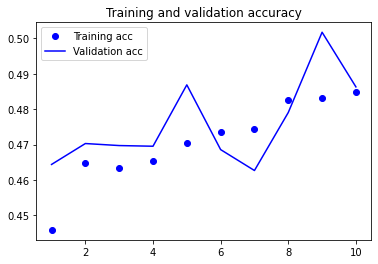

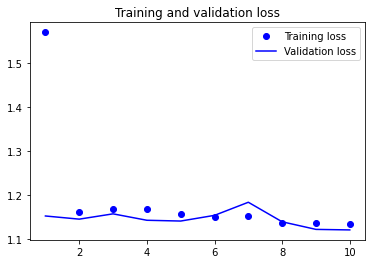

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()